pygeohydro.readthedocs.io# Explore methods to develop cross-section tool and synthetic rating curve
* Use Hydrodata packages to search NLDI and grab 3dep DEMs: pygeohydro.readthedocs.io
* USGS 06721000 SOUTH PLATTE RIVER AT FORT LUPTON, CO.

Richard McDonald rmcd@usgs.gov

In [1]:
from nldi_el_serv.XSGen import XSGen
from nldi_el_serv.dem_query import query_dems_shape
import py3dep
from pynhd import NLDI, NHDPlusHR, WaterData
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import dataretrieval.nwis as nwis
try:
    from nldi_el_serv.__openChannel import flowEst
except ImportError:
    from .__openChannel import flowEst

2021-04-14: Some recent changes to what was the hydrodata stack (https://pypi.org/project/hydrodata/) is now the HyRiver stack and some changes were made to the NLDI function.  Gone is the optional argument basin=true/false to getfeature_byid.  Now there is a new function get_basins.  Resulted in some minor changes to the code.

In [2]:
gagebasin = NLDI().get_basins("06721000").to_crs('epsg:3857')

### Use NLDI feature to grab USGS gage and associated NHD stream segment

In [3]:
gageloc = NLDI().getfeature_byid("nwissite", "USGS-06721000").to_crs('epsg:3857')

<AxesSubplot:>

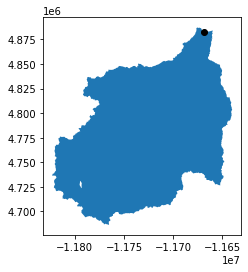

In [4]:
ax = plt.subplot(111)
gagebasin.plot(ax=ax)
gageloc.plot(ax=ax, color='black')


In [5]:
gagebasin = NLDI().get_basins("06721000").to_crs('epsg:3857')
gageloc = NLDI().getfeature_byid("nwissite", "USGS-06721000").to_crs('epsg:3857')
cid = gageloc.comid.values.astype(str)
print(cid,gageloc.comid.values.astype(int)[0] ) 
# strmseg_basin = NLDI().getfeature_byid("comid", cid[0], basin=True).to_crs('epsg:3857')
strmseg_loc = NLDI().getfeature_byid("comid", cid[0]).to_crs('epsg:3857')

['225621'] 225621


### From gage location grab associated stream segment comid, and from comid grab stream segment geometry

In [6]:
gageloc

,,geometry,source,sourceName,identifier,name,uri,comid,reachcode,measure,navigation
USGS-06721000,0,POINT (-11668351.296 4882827.164),nwissite,NWIS Sites,USGS-06721000,"SOUTH PLATTE RIVER AT FORT LUPTON, CO.",https://waterdata.usgs.gov/monitoring-location...,225621,10190003000038,54.5836700000,https://labs.waterdata.usgs.gov/api/nldi/linke...


In [7]:
strmseg_loc

,,geometry,source,sourceName,identifier,name,uri,comid,navigation
225621,0,"LINESTRING (-11668411.398 4879619.057, -116684...",comid,NHDPlus comid,225621,,,225621,https://labs.waterdata.usgs.gov/api/nldi/linke...


XSGen class fits a tensioned spline to the stream segment geometry and then generates a cross-section given a Width and numpoints (ny) perpendicular to splined stream segment. This could be extended to build a grid or series of cross-section on stream segment and develope a reach averaged cross-section, which would be "like" the HAND method.

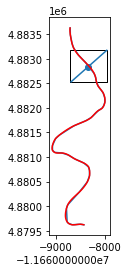

In [33]:
# print(geomfeat.head(), geom2afeat.head())
xs = XSGen(point=gageloc, cl_geom=strmseg_loc, ny=101, width=1000)
xs_line = xs.get_xs()
ax = plt.subplot(111)
gageloc.plot(ax=ax)
strmseg_loc.plot(ax=ax)
xs_line.plot(ax=ax)
xs.get_strm_seg_spine().plot(ax=ax, colors='r')
xs_line.envelope.plot(ax=ax, facecolor="none", edgecolor='black')
plt.show()

In [34]:
print(type(xs_line.envelope.bounds))
print(xs_line.envelope.bounds)
print(strmseg_loc.to_crs('epsg:4326'))

<class 'pandas.core.frame.DataFrame'>
           minx          miny          maxx          maxy
0 -1.166870e+07  4.882519e+06 -1.166795e+07  4.883181e+06
                                                   geometry source  \
225621 0  LINESTRING (-104.81912 40.09405, -104.81987 40...  comid   

             sourceName identifier name uri   comid  \
225621 0  NHDPlus comid     225621           225621   

                                                 navigation  
225621 0  https://labs.waterdata.usgs.gov/api/nldi/linke...  


In [42]:
xs_line_geom = xs_line.to_crs('epsg:4326')
print(xs_line_geom)
bbox = xs_line_geom.geometry[0].envelope.bounds
print(bbox)
query = query_dems_shape(bbox)
print(query)

            name                                           geometry
0  cross-section  LINESTRING (-104.81497 40.11852, -104.81503 40...
(-104.82169912465143, 40.11397581056567, -104.81496559855262, 40.118523059059896)
{'res_1m': False, 'res_3m': False, 'res_5m': False, 'res_10m': True, 'res_30m': True, 'res_60m': False}


Use py3dep from Hydrodata to retrieve 10m DEM.
* Future work: download available DEM products 10m, 3m, 1m, LIDAR, LIDAR+Topobathy where available

(-11669133.344450291, -11667848.597945362, 4879418.032165656, 4883840.5837143)

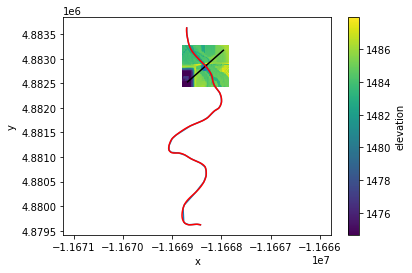

In [36]:
#Buffer bounding box of cross-section otherwise interpolation with elevation below returns nans near end points
t1 = (xs_line.total_bounds) + ((-100.,-100.,100., 100.))
dem = py3dep.get_map("DEM", tuple(t1), resolution=10, geo_crs="EPSG:3857", crs="epsg:3857")

ax = plt.subplot(111)
strmseg_loc.plot(ax=ax)
xs_line.plot(ax=ax, colors='black')
xs.get_strm_seg_spine().plot(ax=ax, colors='r')
xs_line.envelope.plot(ax=ax, facecolor="none", edgecolor='black')
dem.plot(ax=ax)
gageloc.plot(ax=ax)
ax.axis('equal')
# plt.tight_layout()

elevation_bycoords below uses arimap, crappy resolution

In [43]:
# type(xs_line.geometry[0])
# # print(list(xs_line.geometry[0].coords))
# # xs_line.geometry.coords.x
# elev = py3dep.elevation_bycoords(list(xs_line.geometry[0].coords), crs="epsg:3857")

In [44]:
# elev

In [39]:
t1

array([-11668798.17064193,   4882418.78306571, -11667848.59794536,
         4883280.70509478])

Get cross-section points (XSGen class) and interpolate DEM to xs locations, Uses xarray interp method. Not sure how xarray does the interp - needs investigation. For example does it do a nearest neighbor or does it interpolate grid?

<class 'xarray.core.dataarray.DataArray'>


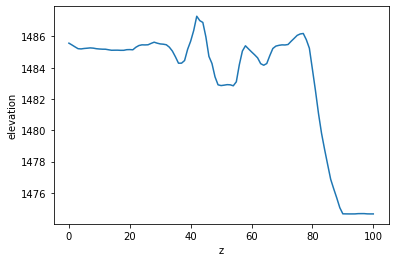

In [40]:
x,y = xs.get_xs_points()
dsx = xr.DataArray(x, dims='z')
dsy = xr.DataArray(y, dims='z')
dsi = dem.interp(x=('z',x), y=('z',y))
dsi.plot()
print(type(dsi))

In [41]:
pdsi = dsi.to_dataframe()
x = dsi.coords['x'].values -dsi.coords['x'].values[0]
y = dsi.coords['y'].values -dsi.coords['y'].values[0]
dist = np.hypot(x,y)
print(dist)
pdsi['distance'] = dist
pdsi

[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.  190.  200.  210.  220.  230.
  240.  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.  350.
  360.  370.  380.  390.  400.  410.  420.  430.  440.  450.  460.  470.
  480.  490.  500.  510.  520.  530.  540.  550.  560.  570.  580.  590.
  600.  610.  620.  630.  640.  650.  660.  670.  680.  690.  700.  710.
  720.  730.  740.  750.  760.  770.  780.  790.  800.  810.  820.  830.
  840.  850.  860.  870.  880.  890.  900.  910.  920.  930.  940.  950.
  960.  970.  980.  990. 1000.]


,x,y,elevation,distance
z,,,,
0,-1.166795e+07,4.883181e+06,1485.567911,0.0
1,-1.166796e+07,4.883174e+06,1485.452338,10.0
2,-1.166796e+07,4.883167e+06,1485.331312,20.0
3,-1.166797e+07,4.883161e+06,1485.214649,30.0
4,-1.166798e+07,4.883154e+06,1485.199355,40.0
...,...,...,...,...
96,-1.166867e+07,4.882545e+06,1474.669498,960.0
97,-1.166868e+07,4.882539e+06,1474.669548,970.0
98,-1.166868e+07,4.882532e+06,1474.653567,980.0


In [32]:
values = dsi.values
lmi = np.where(values == max(values[:49]))[0][0]
rmi = np.where(values == max(values[50:]))[0][0]
print(lmi,rmi, values[lmi], values[rmi])

42 75 1486.9908436272299 1486.1696191887938


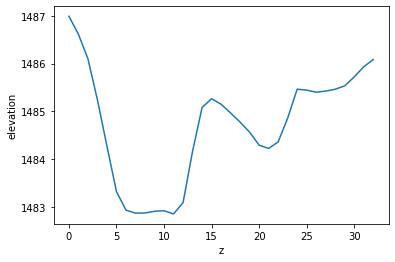

In [18]:
dsi[lmi:rmi].plot()

Calculate distance (stationing) between points for flow calculation.  

In [19]:

x = dsi.coords['x'].values[lmi:rmi] -dsi.coords['x'].values[lmi]
y = dsi.coords['y'].values[lmi:rmi] -dsi.coords['y'].values[lmi]
dist = np.hypot(x,y)
elev = dsi.values[lmi:rmi]
tlen = len(dist)
# print(tlen)
sta2 = np.zeros((tlen,2))
t = []
for index,(tx,ty) in enumerate(zip(dist,elev)):
    if not np.isnan(ty):
        a = np.array((tx,ty))
        sta2[index] = a
#         print(a)
    else:
        t.append(index)

In [20]:
slope = pd.read_csv(r'elevslope.csv')
segslope = slope[slope.COMID==gageloc.comid.values.astype(int)[0]]
segslope.SLOPE.values[0]

0.00170803

Using pyGFT flow calculation steady uniform flow using Manning equation on arbitrary cross-section. I have not tested against some simple cross-sections to verify. Note units are metric

*  simple example where a set of stage values are passed.  Slope is specified from NHD but manning-n is simply specified.  Below we'll calibrate mannin-n over a range of possible values

In [32]:
# d = np.delete(sta2, (t,(0,1)))
min_elev = np.min(sta2[:,1])
max_elev = np.max(sta2[:,0])
max_depth = 5.0
stage_values = np.linspace(min_elev, min_elev+max_depth, 20, dtype=float)
q_values = np.zeros(len(stage_values))
for index,ws in enumerate(stage_values):
    args = flowEst(wsElev=ws,slope=segslope.SLOPE.values[0], n=.025, staElev=sta2, units='m')
    print(f'Q is {args[3]/0.0283}, velocity is {args[4]}top width {args[2]} and maxdepth {args[5]}')
    q_values[index] = args[3]

Q is 0.0, velocity is 0top width 0 and maxdepth 0
Q is 265.24555712732376, velocity is 0.5677819669450509top width 65.67312326926654 and maxdepth 0.263157894736878
Q is 1051.4008892613685, velocity is 0.9385089576281075top width 74.0885434514291 and maxdepth 0.526315789473756
Q is 2282.630965594801, velocity is 1.2447576180117803top width 79.37252804285615 and maxdepth 0.789473684210634
Q is 3903.1033595402114, velocity is 1.5032533259282639top width 84.65651263428319 and maxdepth 1.0526315789472847
Q is 5897.775832982966, velocity is 1.7304582352749436top width 89.95275190173332 and maxdepth 1.3157894736841627
Q is 8246.682483313965, velocity is 1.9307983046062016top width 95.62826279605329 and maxdepth 1.5789473684210407
Q is 10969.186958452883, velocity is 2.1148894907843223top width 101.2822090724845 and maxdepth 1.8421052631579187
Q is 14069.429908612174, velocity is 2.285948430661476top width 106.93615534891887 and maxdepth 2.1052631578947967
Q is 16987.37187509907, velocity is 2

Get gage measurement data from nwis to compare with sythetic rating curve, and get site data to provide gage datum.  Datum could be a problem and attention should ultimately be paid to gage to the vertical datum of gage for example navd88 or ngvd29.  I'm not yet paying attention to that.

In [33]:
site='06721000'
meas = nwis.get_record(sites=site, service='measurements')
si = nwis.get_record(sites=site, service='site')

In [34]:
meas

,agency_cd,site_no,measurement_nu,measurement_dt,tz_cd,q_meas_used_fg,party_nm,site_visit_coll_agency_cd,gage_height_va,discharge_va,measured_rating_diff,gage_va_change,gage_va_time,control_type_cd,discharge_cd
0,USGS,06721000,1,2003-05-14 09:30:00,MDT,Yes,DGS,USGS,4.75,751.0,Fair,-0.01,1.10,Clear,NONE
1,USGS,06721000,2,2003-06-10 13:00:00,MDT,Yes,DGS,USGS,4.76,781.0,Fair,0.01,1.00,Clear,NONE
2,USGS,06721000,3,2003-07-03 07:50:00,MDT,Yes,DGS,USGS,4.48,658.0,Fair,0.01,1.50,Clear,NONE
3,USGS,06721000,4,2003-09-02 12:55:00,MDT,Yes,DGS,USGS,3.98,369.0,Fair,-0.05,1.10,Clear,NONE
4,USGS,06721000,5,2003-10-15 11:40:00,MDT,Yes,DGS,USGS,3.58,209.0,Fair,0.00,0.90,Clear,NONE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,USGS,06721000,165,2020-10-06 08:18:00,MDT,Yes,DBM,USGS,2.96,122.0,Fair,0.03,0.50,Clear,NONE
164,USGS,06721000,166,2020-11-20 08:57:30,MST,Yes,DBM,USGS,3.34,285.0,Fair,0.00,0.68,Clear,NONE
165,USGS,06721000,167,2021-01-05 12:17:30,MST,Yes,DBM,USGS,3.52,311.0,Fair,0.01,0.50,Clear,NONE
166,USGS,06721000,168,2021-02-22 11:05:30,MST,Yes,DBM,Unspe,3.64,368.0,Good,0.01,0.75,Clear,NONE


Might be interesting in some cases to filter measurements

In [35]:
meas1 = meas.loc[(meas['measured_rating_diff'].isin(['Good','Fair','Poor']))]
meas1.head()
meas1.reset_index(inplace = True)

Plot of measured discharges vs synthetic rating curve

C:\Users\rmcd\Miniconda3\envs\nldi_el_serv\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\rmcd\Miniconda3\envs\nldi_el_serv\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


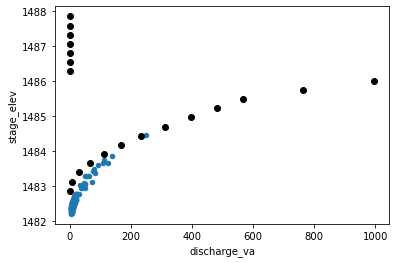

In [36]:
meas1.loc[:,'stage_elev'] = meas1.loc[:,'gage_height_va'].values
# add gage datum to gage measurements
meas1.loc[:,'stage_elev'] += si.loc[:,'alt_va'].values
meas1.loc[:,'stage_elev'] *= 0.3048
meas1.loc[:,'discharge_va'] *= 0.02831
# meas = pd.read_csv('usgs06759500.csv', header=None, names=['stage','discharge'])
ax = plt.subplot(111)
meas1.plot.scatter(x='discharge_va', y='stage_elev', ax = ax)
plt.scatter(q_values, stage_values, color='black')

Same analysis as above but use measured stage values to calculate sythetic flow values and determine rmse of each n-value SRC.
* remove measured stages less than minimum elevation in DEM cross-section 

0.01 89.13392751118765
0.011 75.61969815792332
0.011999999999999999 64.92689324946909
0.012999999999999998 56.51754563646957
0.013999999999999997 50.015225644627755
0.014999999999999996 45.1393645565397
0.015999999999999993 41.65916736855232
0.016999999999999994 39.36333207290656
0.017999999999999995 38.046034027163614
0.018999999999999993 37.50763584915071
0.01999999999999999 37.563803457455734
0.02099999999999999 38.054990337831704
0.021999999999999992 38.8513001312268
0.02299999999999999 39.85212545174151
0.023999999999999987 40.98242310469422
0.024999999999999988 42.18774025902544
0.02599999999999999 43.42937435429148
0.02699999999999999 44.68028502901623
0.027999999999999983 45.92189514476539
0.028999999999999984 47.141694363083246
0.029999999999999985 48.33148828553153
0.030999999999999986 49.48613690672405
0.03199999999999998 50.60265209904512
0.03299999999999998 51.67955393759042
0.03399999999999998 52.71641198576935
0.03499999999999998 53.71351827708302
0.035999999999999976 54

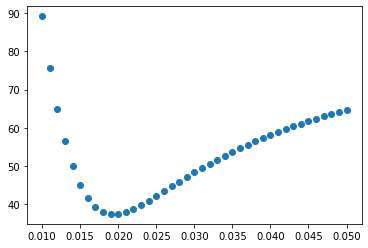

In [37]:
def rmse(meas, sim):
    return np.sqrt(np.square(np.subtract(meas, sim)).mean())

min_elev = np.min(sta2[:,1])
max_elev = np.max(sta2[:,0])
max_depth = 5.0
stage_values = meas1.stage_elev.values
# remove measured stages less than mimimum elevation in DEM cross-section
sv = stage_values[stage_values > min_elev]
mq = meas1.discharge_va.values[stage_values > min_elev]
q_values = np.zeros(len(sv))
nvals = np.arange(0.01,0.051,0.001,dtype=float)
rmse_vals = np.zeros(len(nvals))
calvals = np.zeros((len(nvals),len(q_values)))
for tindex,n in enumerate(nvals):
    for index,ws in enumerate(sv):
        args = flowEst(wsElev=ws,slope=segslope.SLOPE.values[0], n=n, staElev=sta2, units='m')
#         print(f'{index}, ws is {ws}, Q is {args[3]}, MQ is {meas1.discharge_va[index]}')
        q_values[index] = args[3]
        calvals[tindex, index] = args[3]
    print(n, rmse(mq, q_values))
    rmse_vals[tindex] = rmse(mq, q_values)

plt.scatter(nvals, rmse_vals)
print(np.where(rmse_vals == min(rmse_vals)))
minrmse_index = np.where(rmse_vals == min(rmse_vals))[0]

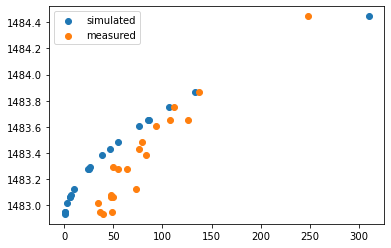

In [38]:
plt.scatter(calvals[minrmse_index,:], sv, label='simulated')
plt.scatter(mq, sv, label='measured')
plt.legend()

In [39]:
meas1.discharge_va

0      21.26081
1      22.11011
2      18.62798
3      10.44639
4       5.91679
         ...   
158     3.45382
159     8.06835
160     8.80441
161    10.41808
162     7.61539
Name: discharge_va, Length: 163, dtype: float64

Quick experiment curve fitting measured data

In [40]:
from scipy.optimize import curve_fit
ds = meas1.discharge_va.values
st = meas1.stage_elev.values
print(len(ds), len(st))

163 163


In [41]:
def func(x, a, b):
    return a + b*np.log(x)
popt,pcov = curve_fit(func, ds, st)

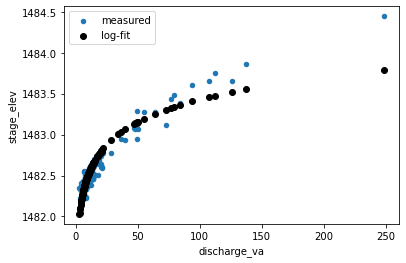

In [42]:
ax = plt.subplot(111)
meas1.plot.scatter(x='discharge_va', y='stage_elev', ax = ax, label='measured')
ax.scatter(ds, func(ds,*popt), color='black', label='log-fit')
plt.legend()
plt.show()

In [43]:
slope = pd.read_csv(r'elevslope.csv')

In [44]:
slope[slope.COMID==3561878]

,COMID,FDATE,MAXELEVRAW,MINELEVRAW,MAXELEVSMO,MINELEVSMO,SLOPE,ELEVFIXED,HWTYPE,STATUSFLAG,SLOPELENKM
24181,3561878,6/30/2009,-9998.0,129917.0,129920.0,129917.0,0.000049,0,NaN,A,0.606


In [45]:
#3561878,6.49,0.09,1328.19,1299.17,1344.73,0,0.606
slope = (1344.73-1299.17)/606.0
print(slope)

0.07518151815181509
